# Introduction

For starters we will use ten different actors, denoted by different video id:s.


We will apply LOGO CV (Leave One Group Out cross-validation)

We will later have to take into account variables like mode (prosody or vocalization) and intensity (1-4) in the cross validation scheme. 

However for the first run it will be fine to include all without taking such factors into account.



In [14]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy
from dotenv import load_dotenv

# Working dir

In [15]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
from src.preprocessing.sql_handling.execute_sql import execute_sql_pandas

# Paths

In [17]:
load_dotenv()

# path to save figures
output_path = os.getenv("VIDEO_OUT")

# Global configuration path
glob_conf_path = '../global_config.py'

In [18]:
output_path

'/home/tim/work/su-thesis-project/emotional-recognition/files/tests/out/video/'

# Load global variables

In [19]:
exec(open(glob_conf_path).read())

# Select data from DB

We only select data that satisfies following three conditions:

* Success == 1
* Confidence rate >= 0.98
* mix (mixed emotions) = False(0)

We also only select the following six video_ids: 'A101', 'A102', 'A18', 'A200'

In [20]:
AU_COLS = ['AU01_r',
'AU02_r',
'AU04_r',
'AU05_r',
'AU06_r',
'AU07_r',
'AU09_r',
'AU10_r',
'AU12_r',
'AU14_r',
'AU15_r',
'AU17_r',
'AU20_r',
'AU23_r',
'AU25_r',
'AU26_r',
'AU45_r']

In [21]:
#query = """SELECT filename,
#video_id,
#emotion_1,
#emotion_1_id,
#frame,
#success,
#confidence,
#AU01_r,
#AU02_r,
#AU04_r,
#AU05_r,
#AU06_r,
#AU07_r,
#AU09_r,
#AU10_r,
#AU12_r,
#AU14_r,
#AU15_r,
#AU17_r,
#AU20_r,
#AU23_r,
#AU25_r,
#AU26_r,
#AU45_r
#FROM openface
#WHERE mix = 0
#AND (intensity_level = 4 OR emotion_1 = 'neu')
#AND situation = 1 
#AND mode = 'v'
#AND video_id IN ('A101', 'A102', 'A18', 'A200', 'A303', 'A227', 'A21', 'A18');"""
#df, read_duration = execute_sql_pandas(query)

In [22]:
query = """SELECT filename,
video_id,
emotion_1,
emotion_1_id,
frame,
success,
confidence,
AU01_r,
AU02_r,
AU04_r,
AU05_r,
AU06_r,
AU07_r,
AU09_r,
AU10_r,
AU12_r,
AU14_r,
AU15_r,
AU17_r,
AU20_r,
AU23_r,
AU25_r,
AU26_r,
AU45_r
FROM openface
WHERE mix = 0
AND video_id = 'A220';"""
df, read_duration = execute_sql_pandas(query)

In [23]:
print("query executed in: {} seconds".format(read_duration))

query executed in: 44.996 seconds


In [24]:
df

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A220_reg_p_2,A220,reg,0,1,1,1,0.00,0.0,2.10,...,1.22,0.00,1.64,0.00,0.52,0.0,0.74,0.40,0.42,0.00
1,A220_reg_p_2,A220,reg,0,2,1,1,0.00,0.0,2.11,...,1.01,0.00,1.72,0.15,0.29,0.0,0.64,0.41,0.37,0.10
2,A220_reg_p_2,A220,reg,0,3,1,1,0.00,0.0,2.06,...,0.88,0.00,1.74,0.15,0.20,0.0,0.59,0.46,0.27,0.10
3,A220_reg_p_2,A220,reg,0,4,1,1,0.00,0.0,2.06,...,0.90,0.00,1.70,0.12,0.27,0.0,0.61,0.42,0.22,0.09
4,A220_reg_p_2,A220,reg,0,5,1,1,0.00,0.0,2.03,...,0.87,0.00,1.72,0.10,0.27,0.0,0.59,0.48,0.35,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98333,A220_anx_v_3,A220,anx,34,306,1,1,0.01,0.0,0.62,...,1.37,0.61,2.10,0.00,0.78,0.0,0.95,0.03,0.00,0.00
98334,A220_anx_v_3,A220,anx,34,307,1,1,0.03,0.0,0.63,...,1.42,0.63,2.08,0.00,0.81,0.0,0.90,0.03,0.00,0.00
98335,A220_anx_v_3,A220,anx,34,308,1,1,0.03,0.0,0.55,...,1.46,0.64,2.03,0.00,0.83,0.0,0.80,0.02,0.00,0.00
98336,A220_anx_v_3,A220,anx,34,309,1,1,0.05,0.0,0.50,...,1.43,0.61,2.02,0.00,0.80,0.0,0.71,0.02,0.00,0.00


Total number of instances: 98338

Number of Instances per File (before data cleaning)
A220_sad_v_4     1084
A220_disa_v_4     989
A220_hap_v_4      812
A220_ang_v_3      662
A220_sha_p_4      645
                 ... 
A220_emb_p_1      114
A220_gra_p_1      112
A220_sex_v_1      107
A220_conf_v_1      90
A220_bor_v_1       82
Name: filename, Length: 352, dtype: int64



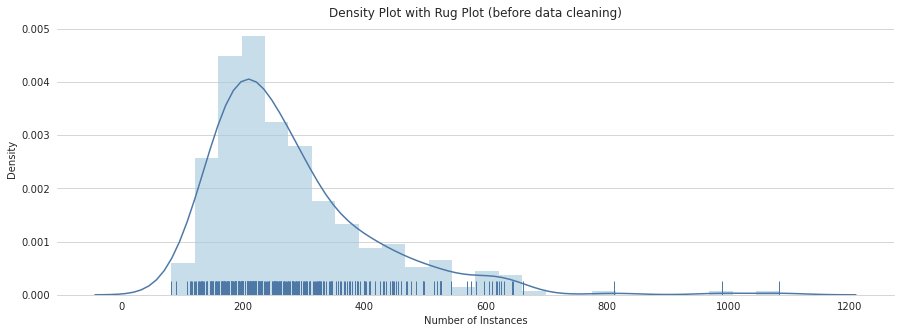


Number of Instances per Video id (before data cleaning)
A220    98338
Name: video_id, dtype: int64


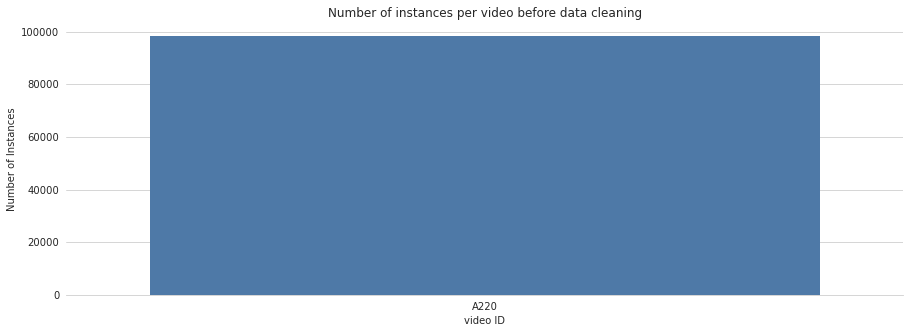


Number of Instances per Emotion (before data cleaning)
ang        4116
sad        3643
disa       3352
neu        3287
hap        2877
rel        2625
fea        2621
awe        2559
sha        2552
conc       2524
reg        2501
gra        2383
env        2353
pri        2348
sat        2346
disg       2339
ple        2310
amu        2292
adm        2245
emb        2243
gui        2238
anx        2202
ele        2199
rej        2184
sex        2168
pea        2078
ins        2068
exc        2052
dou        2041
hop        2012
bor        1994
dist       1948
cont       1946
int        1834
mov        1782
conf       1666
nos        1665
neg_sur    1649
pos_sur    1611
sar        1598
scha       1594
tri        1554
ten        1421
det        1318
Name: emotion_1, dtype: int64


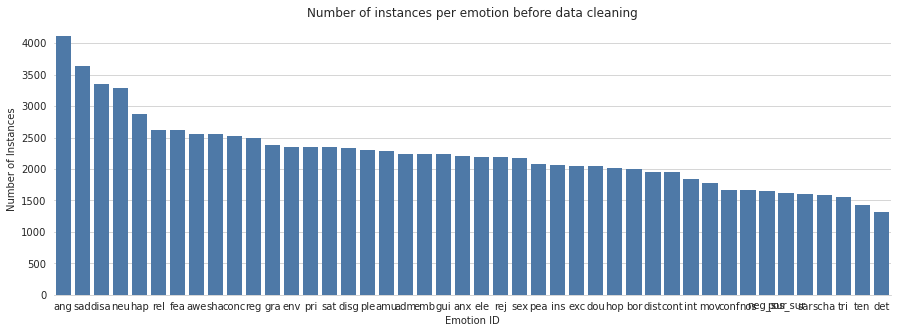


Number of Instances per Success Status (before data cleaning)
1    98338
Name: success, dtype: int64


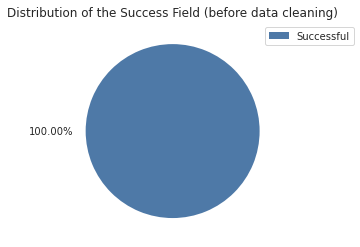


Percentage of Instances per Confidence Rate (before data cleaning)
0    0.00001
1    0.99999
Name: confidence, dtype: float64


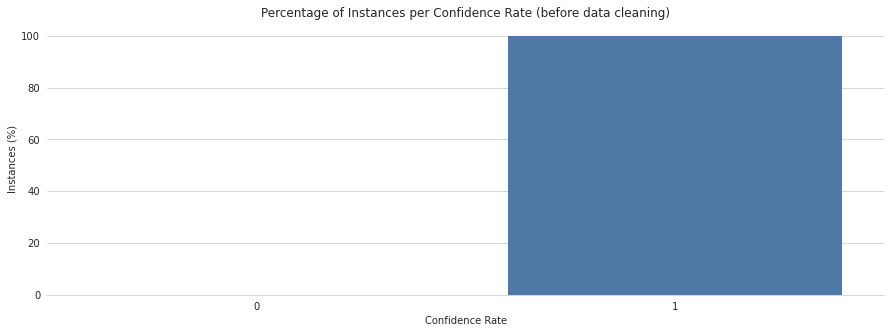

In [25]:
print("Total number of instances: {}".format(len(df)))
print()


print("Number of Instances per File (before data cleaning)")
file_val_counts_original = df["filename"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Video id (before data cleaning)")
video_val_counts_original = df["video_id"].value_counts()
print(video_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(video_val_counts_original.index, video_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per video before data cleaning")
plt.xlabel('video ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (before data cleaning)")
emotion_val_counts_original = df["emotion_1"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion before data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()

print("Number of Instances per Success Status (before data cleaning)")
success_val_counts_original = df["success"].value_counts()
print(success_val_counts_original)
plt.figure()
plt.pie(success_val_counts_original.values, autopct='%1.2f%%', pctdistance= 1.4, colors=palette_def)
plt.legend(['Successful','Unsuccessful'],bbox_to_anchor=(0.9, 1))
plt.savefig(os.path.join(output_path,'charts','report_success_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Distribution of the Success Field (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','success_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

print("Percentage of Instances per Confidence Rate (before data cleaning)")
confidence_val_counts_original = df["confidence"].value_counts(normalize=True).sort_index()
print(confidence_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(confidence_val_counts_original.index, 100*confidence_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.xlabel('Confidence Rate')
plt.ylabel('Instances (%)')
plt.savefig(os.path.join(output_path,'charts','report_confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Percentage of Instances per Confidence Rate (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

In [26]:
print("Number of Instances per video id for every filename")
video_val_counts_original = df[['video_id','filename']].groupby(["video_id"]).filename.nunique().reset_index()
print(video_val_counts_original)
print()

Number of Instances per video id for every filename
  video_id  filename
0     A220       352



## Number of frames for every filename

Number of frames for every filename


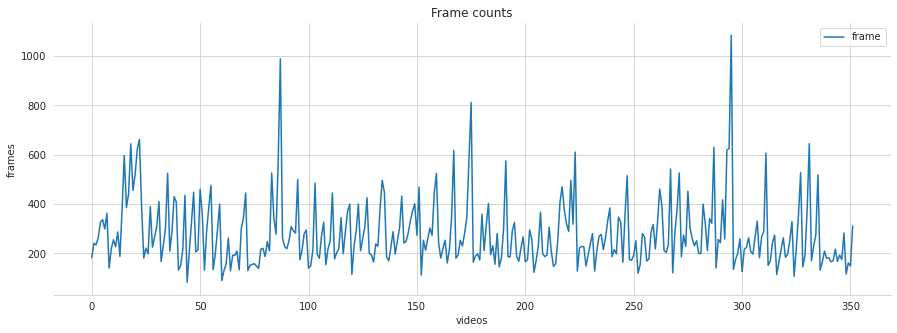

In [27]:
print("Number of frames for every filename")
frame_counts = df[['frame','filename']].groupby(["filename"]).frame.nunique().reset_index()
frame_counts.plot(figsize=(15,5))
plt.title("Frame counts")
plt.xlabel('videos')
plt.ylabel('frames')
plt.show()

## Missing frames grouped by video

In [28]:
def get_unsuccessfull(df):
    ratios = []
    
    # iterate over a df for every filename
    for filename, df_filename in df.groupby('filename'):
        total = df_filename.shape[0]    
        
        # get the sum of all rows with success and greater than 0.98 confidence in df
        successful = (df_filename['success'] == 1).sum()
        confident = (df_filename['confidence'] > 0.98).sum() 

        # calculate ratio between unsuccess or low confidence rows and total number of rows
        success_ratio = successful/total 
        confidence_ratio = confident/total

        if success_ratio < 1 or confidence_ratio < 1:   
            ratios.append({"filename": filename,
                                  "success_ratio": success_ratio,
                                  "confidence_ratio": confidence_ratio})
    # create df from records
    ret_df = pd.DataFrame.from_records(ratios)
    
    # sort values (highest success rate / confident rate first
    ret_df.sort_values(by=['success_ratio', 'confidence_ratio'], inplace = True)
    
    return ret_df

In [29]:
df_ratios = get_unsuccessfull(df)

In [30]:
df_ratios

,filename,success_ratio,confidence_ratio
0,A220_conf_p_2,1.0,0.994949


<Figure size 1080x360 with 0 Axes>

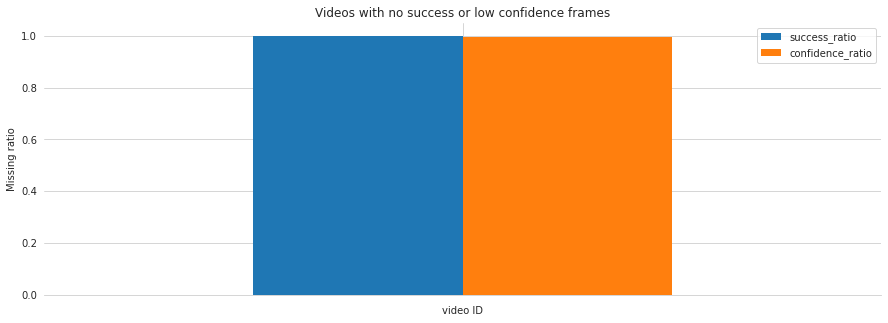

In [31]:
plt.figure(figsize=(15,5))
ax = df_ratios.plot(figsize=(15,5), kind = "bar")
ax.xaxis.set_ticklabels([])

plt.title("Videos with no success or low confidence frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

## Clean the data

Remove all files with too many missing frames

In [32]:
threshold = 0.9

# seems to be some overlapping issue here, look into AND and OR statements

filenames_to_remove = df_ratios[(df_ratios.success_ratio <= threshold) | (df_ratios.confidence_ratio <= threshold)].filename
filenames_to_keep = df_ratios[(df_ratios.success_ratio > threshold) & (df_ratios.confidence_ratio > threshold)].filename
df = df[df.filename.isin(filenames_to_remove) == False]

Inspect result after cleaning

<Figure size 1080x360 with 0 Axes>

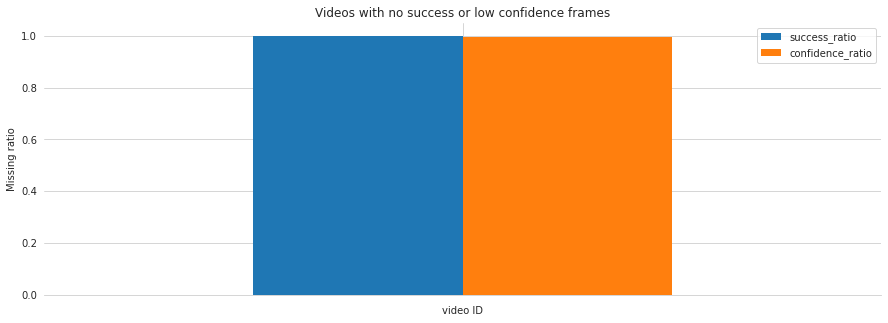

In [33]:
df_new_ratios = get_unsuccessfull(df)

plt.figure(figsize=(15,5))
ax = df_new_ratios.plot(figsize=(15,5), kind = "bar")
ax.xaxis.set_ticklabels([])

plt.title("Videos with no success or low confidence frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

In [34]:
# save an example of a df with missing frames
df_example = df[df['filename'] == filenames_to_keep.iloc[0]]
save_path = os.path.join(output_path, 'success_ratio_90_and_over.csv')
df_example.to_csv(save_path, index=None, header=True)

## Interpolate missing values

In [35]:
df.shape

(98338, 24)

In [36]:
df.isna().sum().sum()

0

In [37]:
# set the AU value of all rows with bad frames to NaN
for au in AU_COLS:
    df.loc[(df['success'] != 1) | (df['confidence'] != 1), au] = np.NaN

In [38]:
df.isna().sum().sum()

17

In [39]:
pd.options.mode.chained_assignment = None  # default='warn'

for filename in filenames_to_keep:    
    df_filename = df[df['filename'] ==  filename]
    
    #print("before")
    #print(df.isna().sum().sum())
    
    df_filename[AU_COLS] = df_filename[AU_COLS].interpolate(method="linear")
    
    df[df['filename'] ==  filename] = df_filename
    
    #print("after")
                                                            
    #print(df.isna().sum().sum())    
    

In [40]:
df.isna().sum().sum()

17

In [41]:
# drop rows that couldn't be interpolated
df = df.dropna()

In [42]:
df.isna().sum().sum()

0

### Plot some examples of interpolated data

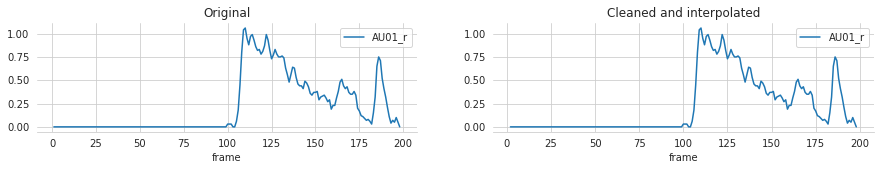

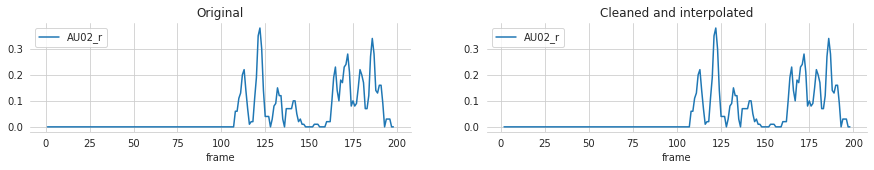

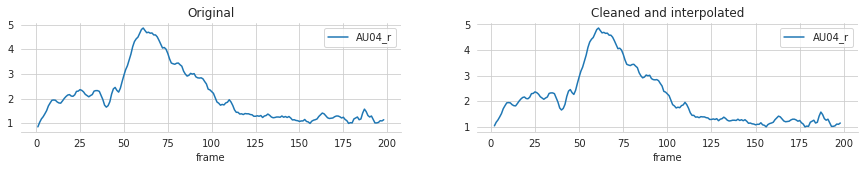

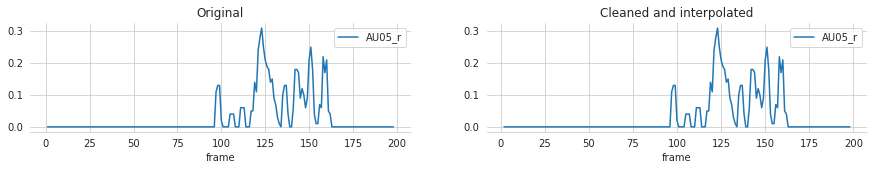

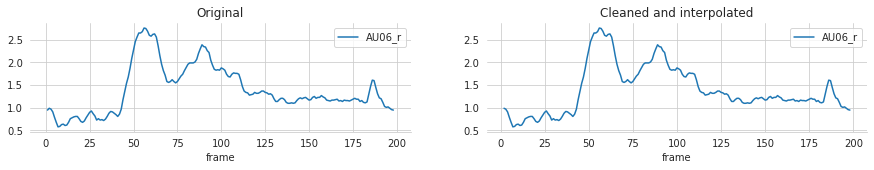

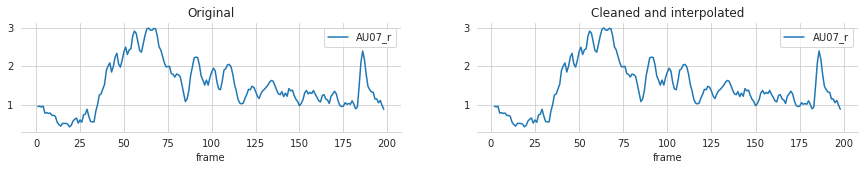

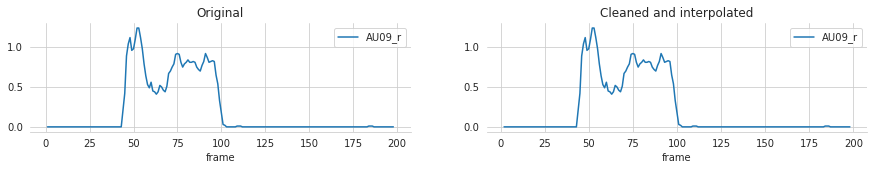

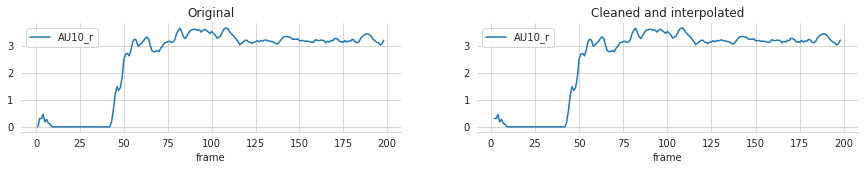

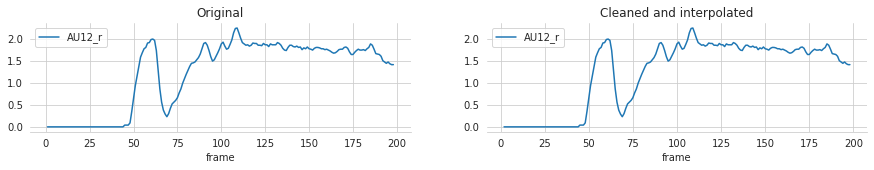

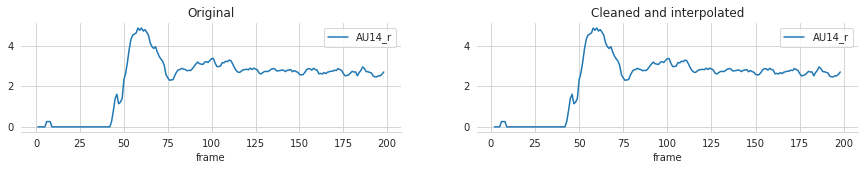

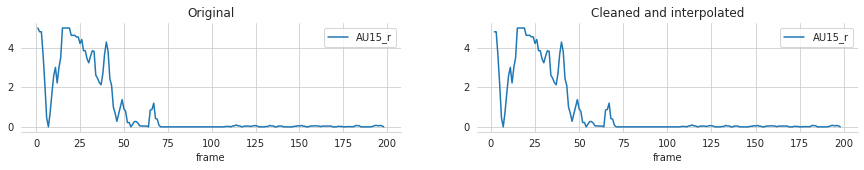

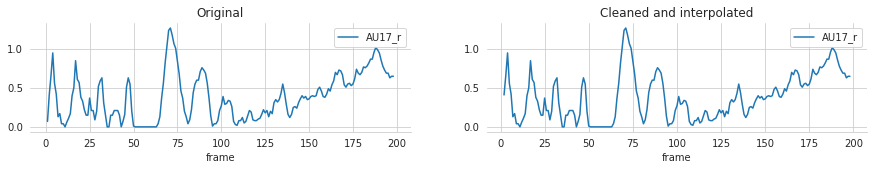

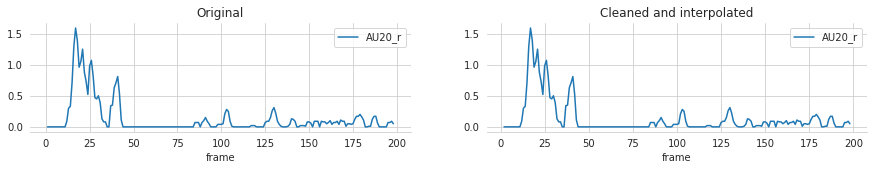

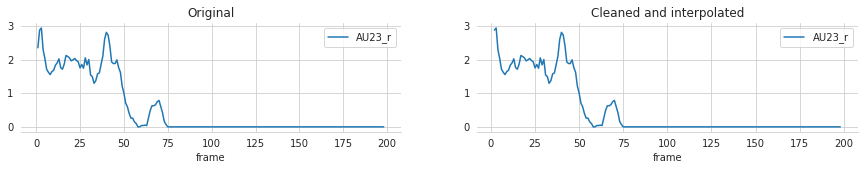

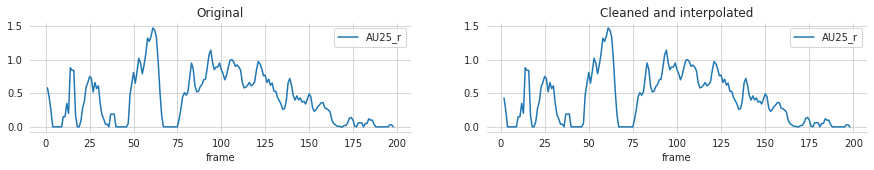

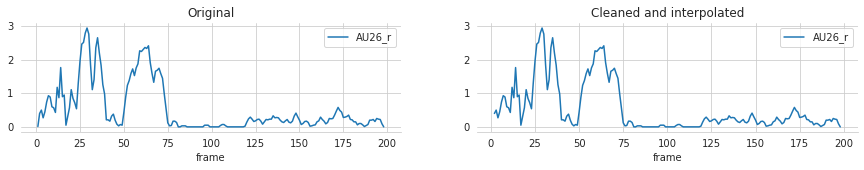

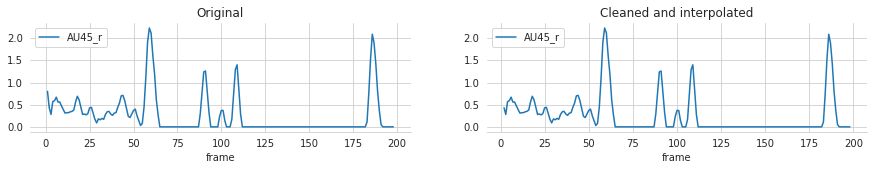

In [43]:
df_example_cleaned = df[df['filename'] == filenames_to_keep.iloc[0]]

for au in AU_COLS:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title("Original")
    axes[1].set_title("Cleaned and interpolated")

    df_example.plot(x = 'frame', y = au, ax=axes[0], figsize=(15, 2))
    df_example_cleaned.plot(x = 'frame', y = au, ax=axes[1], figsize=(15, 2))

# Normalize training set

Merge on filename index... Merge with metadata afterwards...

A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

In [44]:
df.reset_index(drop = True, inplace=True)

In [45]:
from sklearn import preprocessing

# get the metadata from original dataframe

df_metadata = df[['filename', "frame", "video_id", "emotion_1_id"]]

print(df_metadata.shape)

# get only features
X = df.drop(columns=['filename', "frame", "video_id", "emotion_1", "emotion_1_id", "confidence", "success"])
# check for null values
print(np.isnan(np.sum(X)))


min_max_scaler = preprocessing.MinMaxScaler()

# Fit and transform features
X_scaled = min_max_scaler.fit_transform(X)

# check for null values
print(np.isnan(np.sum(X_scaled)))


# Create a dataframe from normalized features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())
print(X_scaled_df.isna().sum().sum())

print(X_scaled_df.shape)


# join back on index with filename dataframe
X_scaled_df = df_metadata.join(X_scaled_df)
print(X_scaled_df.isna().sum().sum())


(98337, 4)
AU01_r    False
AU02_r    False
AU04_r    False
AU05_r    False
AU06_r    False
AU07_r    False
AU09_r    False
AU10_r    False
AU12_r    False
AU14_r    False
AU15_r    False
AU17_r    False
AU20_r    False
AU23_r    False
AU25_r    False
AU26_r    False
AU45_r    False
dtype: bool
False
0
(98337, 17)
0


In [46]:
df_metadata

,filename,frame,video_id,emotion_1_id
0,A220_reg_p_2,1,A220,0
1,A220_reg_p_2,2,A220,0
2,A220_reg_p_2,3,A220,0
3,A220_reg_p_2,4,A220,0
4,A220_reg_p_2,5,A220,0
...,...,...,...,...
98332,A220_anx_v_3,306,A220,34
98333,A220_anx_v_3,307,A220,34
98334,A220_anx_v_3,308,A220,34
98335,A220_anx_v_3,309,A220,34


In [47]:
X_scaled_df

,filename,frame,video_id,emotion_1_id,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A220_reg_p_2,1,A220,0,0.000,0.0,0.420,0.0,0.0,0.137778,...,0.244,0.000000,0.328,0.000,0.119816,0.0,0.168950,0.080,0.120690,0.000000
1,A220_reg_p_2,2,A220,0,0.000,0.0,0.422,0.0,0.0,0.057778,...,0.202,0.000000,0.344,0.030,0.066820,0.0,0.146119,0.082,0.106322,0.020080
2,A220_reg_p_2,3,A220,0,0.000,0.0,0.412,0.0,0.0,0.024444,...,0.176,0.000000,0.348,0.030,0.046083,0.0,0.134703,0.092,0.077586,0.020080
3,A220_reg_p_2,4,A220,0,0.000,0.0,0.412,0.0,0.0,0.057778,...,0.180,0.000000,0.340,0.024,0.062212,0.0,0.139269,0.084,0.063218,0.018072
4,A220_reg_p_2,5,A220,0,0.000,0.0,0.406,0.0,0.0,0.053333,...,0.174,0.000000,0.344,0.020,0.062212,0.0,0.134703,0.096,0.100575,0.010040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98332,A220_anx_v_3,306,A220,34,0.002,0.0,0.124,0.0,0.0,0.104444,...,0.274,0.144550,0.420,0.000,0.179724,0.0,0.216895,0.006,0.000000,0.000000
98333,A220_anx_v_3,307,A220,34,0.006,0.0,0.126,0.0,0.0,0.102222,...,0.284,0.149289,0.416,0.000,0.186636,0.0,0.205479,0.006,0.000000,0.000000
98334,A220_anx_v_3,308,A220,34,0.006,0.0,0.110,0.0,0.0,0.102222,...,0.292,0.151659,0.406,0.000,0.191244,0.0,0.182648,0.004,0.000000,0.000000
98335,A220_anx_v_3,309,A220,34,0.010,0.0,0.100,0.0,0.0,0.075556,...,0.286,0.144550,0.404,0.000,0.184332,0.0,0.162100,0.004,0.000000,0.000000


In [48]:
save_path = os.path.join(output_path, 'video_data_time_series_reduced.csv')
X_scaled_df.to_csv(save_path, index=None, header=True)